# Create Meta Data for Cryptol training examples

## McCabe Cyclomatic Complexity
The json files being used to compute the MCC are in the following format:

```json
{
    "definitions": [
        {
            "kind": "",
            "locals": [],
            "mcc": [] | null,
            "name": "",
            "params": [],
            "references": [],
            "signature": null
        }
    ],
    "imports": [],
    "filename": ""
}
```
This notebook creates the json above for each training example, creates a dataframe to store the json path, filename, and MCC summary statistics for each training example.

In [1]:
from pathlib import Path 
import os, dotenv, yaml

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

dotenv.load_dotenv()
os.chdir(Path(config["pythonpath"]).expanduser())

In [16]:
import numpy as np
import pandas as pd, seaborn as sns
import matplotlib.pyplot as plt
import json

In [3]:
import subprocess
import pandas as pd

VARIATION = "nocomments"
VERSION = config["version"]
REPO_ROOT_DIR = Path(config["repo_root"]).expanduser()


MCC_ROOT_DIR = Path(config["mcc_root"]).expanduser()
MCC_ROOT_DIR.mkdir(parents=True, exist_ok=True)

clean_data_df = pd.read_json(
    f"data/clean_datasets/{VARIATION}_{VERSION}.jsonl", 
    lines=True
    )

CABAL_PROJECT_ROOT = "toy-cryptol-ast" 

clean_data_df.head()

,filename,filetype,content,variant,n_imports_original,n_imports_final
0,AES-GCM-SIV-proof/proof/cryptol-specs/AES.cry,cry,module AES where\n\nimport `Common::AES\n\ntyp...,without_comments,NaN,NaN
1,AES-GCM-SIV-proof/proof/cryptol-specs/AES128.cry,cry,module AES128 where\n\nimport `Common::AES\nim...,without_comments,NaN,NaN
2,AES-GCM-SIV-proof/proof/cryptol-specs/AES256.cry,cry,module AES256 where\n\nimport `Common::AES\nim...,without_comments,NaN,NaN
3,AES-GCM-SIV-proof/proof/asm/cryptol/X86.cry,cry,module X86 where\n\nimport AES128\n\naesenc : ...,without_comments,NaN,NaN
4,aws-lc-verification/cryptol-specs/Common/Field...,cry,module Common::Field where\n\nimport Common::M...,without_comments,NaN,NaN


In [4]:
def run_haskell_mcc_generator(cry_path: Path):
    """
    Call: cabal run toy-cryptol-ast -- <file> <OUTDIR>
    from within CABAL_PROJECT_ROOT.
    """

    cmd = [
        "cabal",
        "run",
        "cryptol-meta",
        "--",
        str(cry_path),
    ]

    print("Running:", " ".join(cmd))
    result = subprocess.run(
        cmd,
        cwd=str(CABAL_PROJECT_ROOT),  # run inside the cabal project
        capture_output=True,
        text=True,
    )


    if result.stderr.strip():
        print("STDERR:\n", result.stderr)

    return result


In [5]:
from src.preprocessing.mcc_tools import summarize_file_obj

#clean_data_df = clean_data_df.iloc[ -10 : ]
meta_rows = []

for index, row in clean_data_df.iterrows():
    cry_path = Path(row["filename"])
    json_path = cry_path.parent / f"{cry_path.stem}.json"
    output_file = MCC_ROOT_DIR / json_path
    output_file.parent.mkdir(parents=True, exist_ok=True)
    res = run_haskell_mcc_generator(REPO_ROOT_DIR / cry_path)
    mcc = json.loads(res.stdout)
    output_file.write_text(
        json.dumps(mcc, indent=2),
        encoding="utf-8"
        )
    summary = summarize_file_obj(mcc)
    meta_rows.append(
        {
            "filename": row["filename"],
            "json_path": str(json_path),
            **summary,
        }
    )

meta_df = pd.DataFrame(meta_rows)

Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/AES-GCM-SIV-proof/proof/cryptol-specs/AES.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/AES-GCM-SIV-proof/proof/cryptol-specs/AES128.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/AES-GCM-SIV-proof/proof/cryptol-specs/AES256.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/AES-GCM-SIV-proof/proof/asm/cryptol/X86.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/aws-lc-verification/cryptol-specs/Common/Field.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/aws-lc-verification/cryptol-specs/Common/mod_arith.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasoning_for_Cryptography/aws-lc-verification/cryptol-specs/Common/ModDivZ.cry
Running: cabal run cryptol-meta -- /Users/josh/Automated_Reasonin

In [6]:
meta_df.head(10)

,filename,json_path,imports,imports_count,num_definitions,num_declarations,num_types,num_declarations_with_mcc,total_mcc,max_mcc,avg_mcc
0,AES-GCM-SIV-proof/proof/cryptol-specs/AES.cry,AES-GCM-SIV-proof/proof/cryptol-specs/AES.json,[`Common::AES],1,5,4,1,4,4,1.0,1.000000
1,AES-GCM-SIV-proof/proof/cryptol-specs/AES128.cry,AES-GCM-SIV-proof/proof/cryptol-specs/AES128.json,"[`Common::AES, `Common::AES as AES, AES as AES]",3,9,6,3,6,6,1.0,1.000000
2,AES-GCM-SIV-proof/proof/cryptol-specs/AES256.cry,AES-GCM-SIV-proof/proof/cryptol-specs/AES256.json,"[`Common::AES, `Common::AES as AES, AES as AES]",3,9,6,3,6,6,1.0,1.000000
3,AES-GCM-SIV-proof/proof/asm/cryptol/X86.cry,AES-GCM-SIV-proof/proof/asm/cryptol/X86.json,[AES128],1,13,13,0,13,15,2.0,1.153846
4,aws-lc-verification/cryptol-specs/Common/Field...,aws-lc-verification/cryptol-specs/Common/Field...,"[Common::Morphism, Common::Set]",2,1,0,1,0,0,NaN,NaN
5,aws-lc-verification/cryptol-specs/Common/mod_a...,aws-lc-verification/cryptol-specs/Common/mod_a...,[Common::bv],1,10,10,0,10,19,4.0,1.900000
6,aws-lc-verification/cryptol-specs/Common/ModDi...,aws-lc-verification/cryptol-specs/Common/ModDi...,[],0,5,5,0,5,10,4.0,2.000000
7,aws-lc-verification/cryptol-specs/Common/Set.cry,aws-lc-verification/cryptol-specs/Common/Set.json,[],0,6,5,1,5,6,2.0,1.200000
8,aws-lc-verification/cryptol-specs/Common/Morph...,aws-lc-verification/cryptol-specs/Common/Morph...,[Common::Set],1,9,7,2,7,7,1.0,1.000000
9,aws-lc-verification/cryptol-specs/Common/bv.cry,aws-lc-verification/cryptol-specs/Common/bv.json,[],0,9,9,0,9,9,1.0,1.000000


In [15]:
meta_df.fillna(0, inplace=True)

meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   filename                   783 non-null    object 
 1   json_path                  783 non-null    object 
 2   imports                    783 non-null    object 
 3   imports_count              783 non-null    int64  
 4   num_definitions            783 non-null    int64  
 5   num_declarations           783 non-null    int64  
 6   num_types                  783 non-null    int64  
 7   num_declarations_with_mcc  783 non-null    int64  
 8   total_mcc                  783 non-null    int64  
 9   max_mcc                    783 non-null    float64
 10  avg_mcc                    783 non-null    float64
dtypes: float64(2), int64(6), object(3)
memory usage: 67.4+ KB


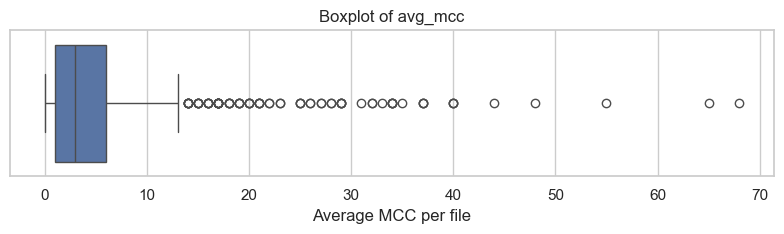

In [21]:
sns.set_theme(style="whitegrid")

plt.figure(figsize=(8, 2.5))
sns.boxplot(
    x=meta_df["num_declarations_with_mcc"]
)

plt.xlabel("Average MCC per file")
plt.title("Boxplot of avg_mcc")

plt.tight_layout()
plt.show()

In [24]:
meta_df["avg_mcc_bucket_q3"] = pd.qcut(
    meta_df["avg_mcc"],
    q=3,
    labels=["low", "mid", "high"]
)

num_cols = [
    "imports_count",
    "num_definitions",
    "num_declarations",
    "num_types",
    "num_declarations_with_mcc",
    "total_mcc",
    "max_mcc",
    "avg_mcc",
]

pearson = meta_df[num_cols].corr(method="pearson")["avg_mcc"].sort_values(ascending=False)
spearman = meta_df[num_cols].corr(method="spearman")["avg_mcc"].sort_values(ascending=False)

print("Pearson correlation vs avg_mcc:\n", pearson)
print("\nSpearman correlation vs avg_mcc:\n", spearman)

Pearson correlation vs avg_mcc:
 avg_mcc                      1.000000
max_mcc                      0.776799
total_mcc                    0.204991
num_declarations             0.114251
num_declarations_with_mcc    0.113711
num_definitions              0.075433
imports_count                0.046117
num_types                   -0.086016
Name: avg_mcc, dtype: float64

Spearman correlation vs avg_mcc:
 avg_mcc                      1.000000
max_mcc                      0.954662
total_mcc                    0.624459
num_declarations_with_mcc    0.448410
num_declarations             0.447302
num_definitions              0.338651
imports_count                0.011793
num_types                   -0.005137
Name: avg_mcc, dtype: float64


In [26]:
bucket_col = "avg_mcc_bucket_q3"  # or q5 / fixed

summary = (
    meta_df.groupby(bucket_col, observed=True)[num_cols]
      .agg(["count", "mean", "median", "std"])
)

summary

imports_count                            num_definitions  \
                          count      mean median       std           count   
avg_mcc_bucket_q3                                                            
low                         455  0.810989    0.0  1.252086             455   
mid                          74  0.945946    1.0  1.071318              74   
high                        254  0.665354    0.0  1.170377             254   

                                               num_declarations             \
                        mean median        std            count       mean   
avg_mcc_bucket_q3                                                            
low                 3.938462    3.0   5.700351              455   2.885714   
mid                17.932432   14.0  13.719630               74  16.351351   
high                8.299213    5.0   9.021989              254   7.232283   

                   ... total_mcc            max_mcc                   \
                   ...    median        std   count      mean median   
avg_mcc_bucket_q3  ...                                                 
low                ...       2.0   4.121393     455  0.819780    1.0   
mid                ...      13.5  15.061001      74  2.108108    2.0   
high               ...       7.0  11.468519     254  2.732283    2.0   

                            avg_mcc                                
                        std   count      mean    median       std  
avg_mcc_bucket_q3                                                  
low                0.384793     455  0.819780  1.000000  0.384793  
mid                0.353750      74  1.158043  1.163333  0.058428  
high               1.113686     254  1.759519  1.500000  0.600327  

[3 rows x 32 columns]

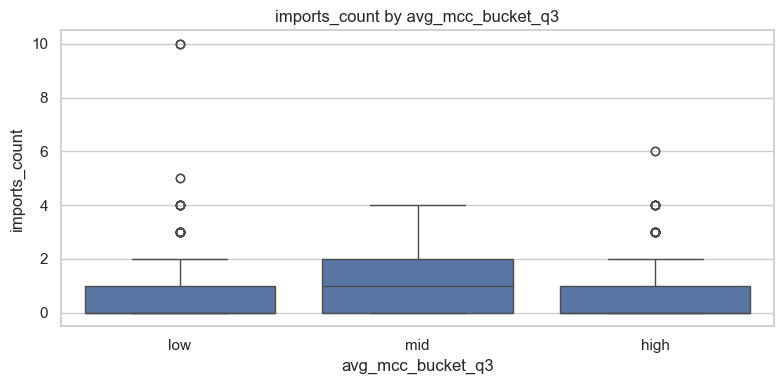

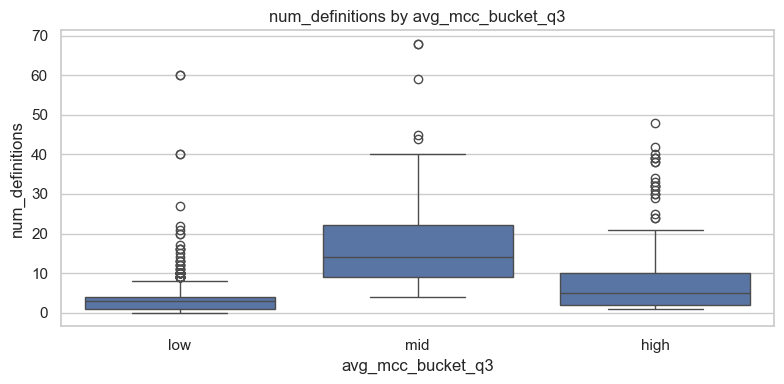

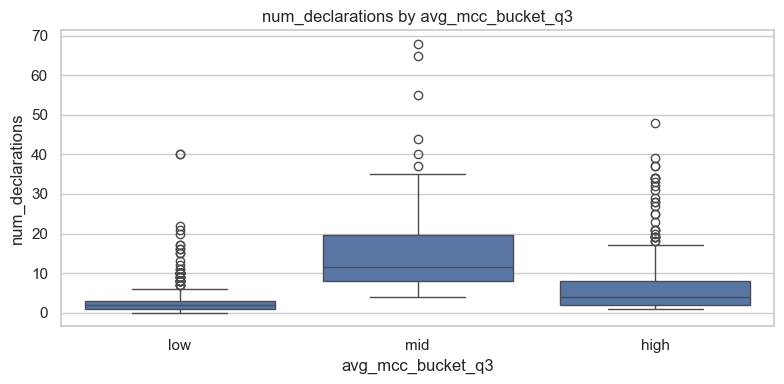

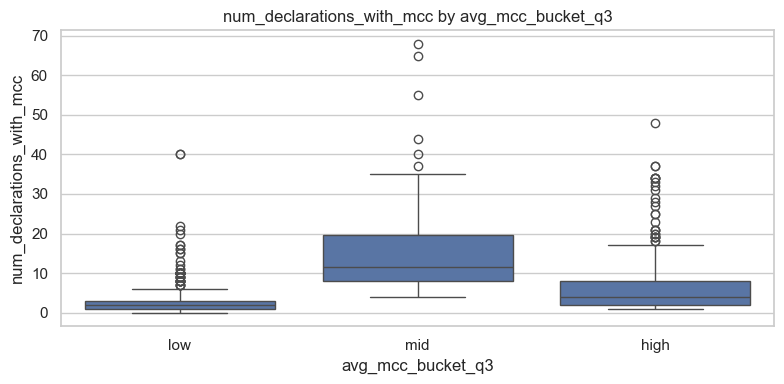

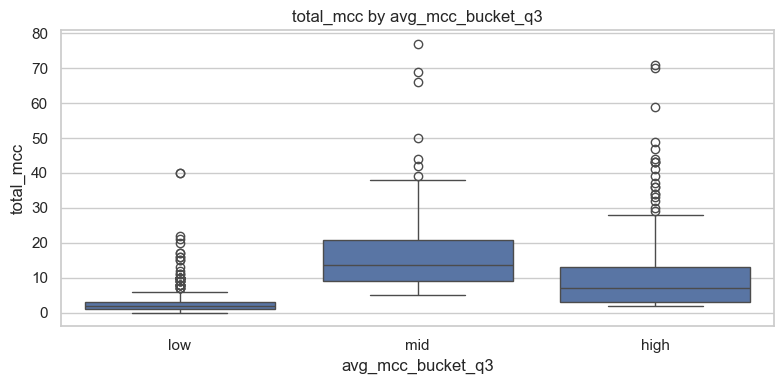

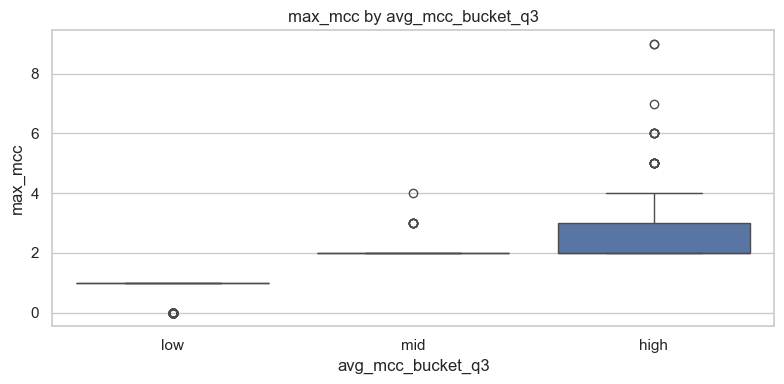

In [28]:
features_to_compare = [
    "imports_count",
    "num_definitions",
    "num_declarations",
    "num_declarations_with_mcc",
    "total_mcc",
    "max_mcc",
]

for col in features_to_compare:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data=meta_df, x=bucket_col, y=col)
    plt.title(f"{col} by {bucket_col}")
    plt.tight_layout()
    plt.show()